In [1]:
from __future__ import division  # Python 2 compatibility
from scipy.special import binom
from scipy.interpolate import RectBivariateSpline
import numpy as np
import time
from concurrent.futures import ThreadPoolExecutor
import heapq
import math 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
class TimeModel:
    """A class representing a model for calculating time-based paths."""

    def __init__(self, filename, width):
        """
        Initializes the TimeModel.

        Parameters:
        - start_lat_long (tuple): Tuple containing start latitude and longitude.
        - end_lat_long (tuple): Tuple containing end latitude and longitude.
        """
        # Read the bathymetry data from a file (specified by sys.argv[1])
        self.lines = self.readlines(filename)

        # Extract grid properties (ncols, nrows, etc.) from the read lines
        self.ncols = int([item for item in self.lines[0].split() if item.isdigit()][0])  # Extract the number of columns
        self.nrows = int([item for item in self.lines[1].split() if item.isdigit()][0])  # Extract the number of rows
        self.xllcorner =  float([item for item in self.lines[2].split() if self.is_number(item)][0])  # Extract x-coordinate of lower left corner
        self.yllcorner = float([item for item in self.lines[3].split() if self.is_number(item)][0])  # Extract y-coordinate of lower left corner
        self.cellsize = float([item for item in self.lines[4].split() if self.is_number(item)][0]) # Extract cell size
        # Create a matrix/grid using data starting from line 7
        self.grid = self.make_matrix(self.lines[6:])

        # Generate latitude and longitude grid used to pinpoint specific depths
        self.lat_long_grid = self.generate_lat_long_grid()

        self.width = width
        
    def is_number(self, s):
        try:
            float(s)  # Try to convert the string to a float
            return True
        except ValueError:
            return False

    def make_matrix(self, lines):
        # Converts the bathymetry data into a grid
        matrix = []
        for line in lines:
            line = line.split()
            new_line = [int(num) for num in line]
            matrix.append(new_line)
        return matrix

    def readlines(self, filename):
        # Reads in the bathymetry data
        with open(filename) as file:
            return file.readlines()

    def dijkstras_algorithm(self, start_lat_long, end_lat_long):
        """
        Implementation of Dijkstra's algorithm to find the shortest path.

        Returns:
        - lat_long_path (list): Shortest path in latitude and longitude coordinates.
        - total_time (float): Total time taken for the shortest path.
        """
        # Calculate the dimensions of the bathymetry grid
        rows = self.nrows
        cols = self.ncols
        
        start_point = self.find_start_point(self.shifted_start(start_lat_long, end_lat_long))
        end_point = self.find_start_point(end_lat_long)

        # Initialize distance and visited dictionaries
        # distance: Keeps track of the minimum distance to each node
        # visited: Keeps track of the previous node in the path
        distance = {start_point: 0}  # Start node has distance 0
        for row in range(rows):
            for col in range(cols):
                if self.grid[row][col] >= 0:
                    # Initialize all other nodes with infinite distance
                    distance[(row, col)] = float('inf')
        visited = {start_point: None}  # Start node has no previous node

        # Initialize the priority queue
        queue = [(0, start_point)]  # Heap queue sorted by shortest distance
        heapq.heapify(queue)

        while queue:
            # Get the node with the minimum distance from the queue
            current_time, current_node = heapq.heappop(queue)

            # Check if we have reached the end point
            if current_node == end_point:
                break

            # Explore the neighbors of the current node
            for neighbor in self.get_neighbors(current_node, rows, cols):
                if self.grid[neighbor[0]][neighbor[1]] >= 0:
                    continue # Skip obstacles or non-traversable nodes(nodes on land)

                # Calculate time required to move from current node to neighbor
                neighbor_depth = self.grid[neighbor[0]][neighbor[1]]
                current_depth = self.grid[current_node[0]][current_node[1]]
                time = (self.cellsize*111111) / (math.sqrt(((abs(current_depth) + abs(neighbor_depth)) / 2) * 9.8))

                # Calculate the new time for the neighbor through the current node
                new_time = distance[current_node] + time

                # Update if the new time to reach neighbor is shorter
                if neighbor not in distance or new_time < distance[neighbor]:
                    distance[neighbor] = new_time
                    visited[neighbor] = current_node  # Update previous node
                    heapq.heappush(queue, (new_time, neighbor))  # Push updated time and node to queue

        # Reconstruct the path from start to end
        path = []
        current = end_point
        while current:
            # path.append(current)
            # current = visited[current]
            try:
                path.append(current)
                current = visited[current]
            except (KeyError, TypeError) as e: # if an error gets thrown here,
                return None, -1                 # that means that the surrounding lat longs are all positive elevation


        path.reverse()  # Reverse to get the path from start to end
        lat_long_path = self.convert_path_to_lat_long(path)
        total_time = distance[end_point]  # Total time taken for the shortest path
        return lat_long_path, total_time/60

    def get_neighbors(self, node, rows, cols):
        """
        Retrieves neighboring nodes of a given node within the grid boundaries.

        Parameters:
        - node (tuple): Coordinates of the current node (row, col).
        - rows (int): Total rows in the grid.
        - cols (int): Total columns in the grid.

        Returns:
        - neighbors (list): List of neighboring nodes.
        """
        neighbors = []  # Initialize an empty list to store neighboring nodes
        row, col = node  # Unpack the current node's coordinates

        # Explore adjacent nodes and check grid boundaries
        # Append valid neighboring nodes to the 'neighbors' list
        if row > 0:
            neighbors.append((row - 1, col))  # Upper neighbor
        if row < rows - 1:
            neighbors.append((row + 1, col))  # Lower neighbor
        if col > 0:
            neighbors.append((row, col - 1))  # Left neighbor
        if col < cols - 1:
            neighbors.append((row, col + 1))  # Right neighbor

        return neighbors

    def generate_lat_long_grid(self):
        """
        Generates a grid of latitude and longitude coordinates.

        Returns:
        - grid (list): Grid of latitude and longitude coordinates.
        """
        start_value = (self.xllcorner, self.yllcorner)  # Starting latitude and longitude to line up with the bathymetry data
        increment = self.cellsize
        rows = self.nrows
        columns = self.ncols

        grid = []
        for row in range(rows):
            current_row = []
            for col in range(columns):
                value = (start_value[0] + col * increment, start_value[1] + row * increment)
                current_row.append(value)
            grid.append(current_row)

        return grid[::-1]  # Flipping the grid and returning it

    def find_start_point(self, lat_long_point):
        """
        Finds the closest grid point to a given latitude and longitude point.

        Parameters:
        - lat_long_point (tuple): Latitude and longitude coordinates.

        Returns:
        - closest_position (tuple): Closest grid point coordinates.
        """
        closest_value_diff = float('inf')  # Initialize a variable to track the closest value difference
        closest_position = (0,0) # Initialize a variable to store the closest position

        # Iterate through the grid to find the closest grid point
        for i in range(len(self.lat_long_grid)):
            for j in range(len(self.lat_long_grid[i])):
                current_tuple = self.lat_long_grid[i][j]  # Get current grid point coordinates

                # Calculate the absolute difference between the points
                value_diff = sum(abs(x - y) for x, y in zip(lat_long_point, current_tuple))

                # Check if the current grid point is closer than the previously closest one
                # and self.grid[closest_position[0]][closest_position[1]] < 0
                thing = self.grid[i][j]
                if value_diff < closest_value_diff and thing < 0:
                    closest_value_diff = value_diff  # Update the closest value difference
                    closest_position = (i, j)  # Update the closest position
        #thing = self.grid[closest_position[0]][closest_position[1]]
        return closest_position   # Return the coordinates of the closest grid point

    def convert_path_to_lat_long(self, path):
        """
        Converts a path of grid points to a list of latitude and longitude coordinates.

        Parameters:
        - path (list): List of grid points.

        Returns:
        - lat_long_path (list): List of latitude and longitude coordinates.
        """
        # Convert each grid point in the path to latitude and longitude coordinates
        lat_long_path = [self.lat_long_grid[row][col] for (row, col) in path]
        return lat_long_path
    
    def compute_derivative(self, h=None, fidelity=1):
        """
        Computes the derivative of the arrival time in the landslide model 
        with respect to latitude and longitude using a finite centered difference
        approximation.

        Parameters:
        - h (int): Step size for the finite difference approximation.

        Returns:
        - derivative (tuple): Tuple containing the derivative of the arrival time
        """

        file_path = r"C:\Users\ashle\Documents\Whitehead Research\Research 2023\1852\etopo.tt3"

        # Initialize the step size
        if type(h) != int or h is None:
            h = self.cellsize


        # Compute the derivative of the arrival time with respect to latitude
        lat_plus_h = (self.start_lat_long[0], self.start_lat_long[1] + h)
        lat_minus_h = (self.start_lat_long[0], self.start_lat_long[1] - h)
        derivative_lat_plus_instance = TimeModel(lat_plus_h, self.end_lat_long, file_path)
        path, arrival_time_plus_h = derivative_lat_plus_instance.dijkstras_algorithm()
        derivative_lat_minus_instance = TimeModel(lat_minus_h, self.end_lat_long, file_path)
        path, arrival_time_minus_h = derivative_lat_minus_instance.dijkstras_algorithm()
        dT_dlat = (arrival_time_plus_h - arrival_time_minus_h) / (2 * h)
        print(f"arrival_time_plus_h: {round(arrival_time_plus_h, 3)}")
        print(f"arrival_time_minus_h: {round(arrival_time_minus_h, 3)}")
        print(f"dT_dlat: {round(dT_dlat, 3)}")
        dT_dlat *= self.cellsize

        # Compute the derivative of the arrival time with respect to longitude
        long_plus_h = (self.start_lat_long[0] + h, self.start_lat_long[1])
        long_minus_h = (self.start_lat_long[0] - h, self.start_lat_long[1])
        derivative_long_plus_instance = TimeModel(long_plus_h, self.end_lat_long, file_path)
        path, arrival_time_plus_h = derivative_long_plus_instance.dijkstras_algorithm()
        derivative_long_minus_instance = TimeModel(long_minus_h, self.end_lat_long, file_path)
        path, arrival_time_minus_h = derivative_long_minus_instance.dijkstras_algorithm()
        dT_dlong = (arrival_time_plus_h - arrival_time_minus_h) / (2 * h)
        print(f"arrival_time_plus_h: {round(arrival_time_plus_h, 3)}")
        print(f"arrival_time_minus_h: {round(arrival_time_minus_h, 3)}")
        print(f"dT_dlong: {round(dT_dlong, 3)}")
        dT_dlong *= self.cellsize

        return [-dT_dlong, -dT_dlat]

    def shifted_start(self, start_lat_long, end_lat_long):
        deg_width = self.width / 111111  # width in meters approximated to degrees
        lon1, lat1 = start_lat_long
        lon2, lat2 = end_lat_long
        dist = math.sqrt((lon2 - lon1) ** 2 + (lat2 - lat1) ** 2) #distance formula
        unit_vector_x = (lon2 - lon1) / dist
        unit_vector_y = (lat2 - lat1) / dist

        x = lon1 + (deg_width/2) * unit_vector_x
        y = lat1 + (deg_width/2) * unit_vector_y

        return x, y

In [3]:
class TimeModelSimpsons:
    """A class to approximate line integrals using Simpson's rule
    based on Bezier curves to model arrival time of a tsunami.

    This class facilitates the calculation of speed functions
    derived from Bezier curves representing geographical path of the tsunami.
    It employs Simpson's rule for numerical integration to
    determine the speed along a path defined by control points.

    Attributes:
        control_points (numpy.ndarray): An array containing control points
            defining the Bezier curve's trajectory.
        matrix (numpy.ndarray): Matrix representation of bathymetry data.
        base_x (numpy.ndarray): Array representing the X-axis values.
        base_y (numpy.ndarray): Array representing the Y-axis values.
        cached_coefficients (dict): Cached binomial coefficients for optimization.

    Methods:
        __init__(self, control_points): Initializes the TimeModelSimpsons instance.
        get_depth(self, lon, lat): Retrieves depth values at given coordinates.
        binomial_coefficient(self, n, k): Computes binomial coefficients.
        bezier_curve(self, control_points, num_points=100): Calculates Bezier curves.
        derivative_bezier_curve(self, control_points, num_points=100): Computes the derivative of Bezier curves.
        get_derivative_at_t(self, control_points, t): Computes derivatives at a given point.
        speed_function(self, t): Computes the speed function at a given time.
        simpson(self, a, b, n, num_threads=24): Approximates definite integrals
            using Simpson's rule with multithreading support.
    """
    # Used to fetch cached values
    cached_coefficients = {}

    def __init__(self, control_points):
        """
        Initializes a TimeModelSimpsons instance.

        Args:
            control_points (numpy.ndarray): An array containing control points
                defining the Bezier curve's trajectory.
        Attributes:
            control_points (numpy.ndarray): An array containing control points defining the Bezier curve's trajectory.
            matrix (numpy.ndarray): Matrix representation of bathymetry data.
            base_x (numpy.ndarray): Array representing the X-axis values.
            base_y (numpy.ndarray): Array representing the Y-axis values.
            bezier_values (Tuple[numpy.ndarray, numpy.ndarray]): Tuple containing arrays
            representing the X and Y values of the Bezier curve.
            bezier_derivative_values (Tuple[numpy.ndarray, numpy.ndarray]): Tuple containing arrays
            representing the X and Y values of the derivative of the Bezier curve.
            cached_coefficients (dict): Cached binomial coefficients for optimization.
        """
        self.control_points = control_points
        self.matrix = np.array(getattr(time_model_instance, "grid")[::-1]).T
        self.base_x = [item[0] for item in getattr(time_model_instance, "lat_long_grid")[0]]
        self.base_y = [row[0][1] for row in getattr(time_model_instance, "lat_long_grid")][::-1]
        self.bezier_values = self.bezier_curve(control_points)
        self.bezier_derivative_values = self.derivative_bezier_curve(control_points)

   
    def get_depth(self, lon, lat):
        """
        Retrieves depth values at given coordinates (longitude and latitude).

        Args:
            lon (float): Longitude coordinate.
            lat (float): Latitude coordinate.

        Returns:
            float: Interpolated depth value at the specified coordinates.
        """

        # Extract the base X, Y, and Z values
        x = self.base_x
        y = self.base_y
        z = np.array(self.matrix)

        # Create an interpolation function using RectBivariateSpline from scipy
        interp_function = RectBivariateSpline(x, y, z)

        # Compute the interpolated depth value at the given coordinates
        interp_value = interp_function(lon, lat)

        return interp_value[0][0]

    def binomial_coefficient(self, n, k):
        """
        Computes binomial coefficients and caches results for optimization.

        Args:
            n (int): Total number of items.
            k (int): Number of items to choose.

        Returns:
            int: Binomial coefficient (n choose k).
        """

        # Check if the binomial coefficient for given n and k is already cached
        if (n, k) in self.cached_coefficients:
            return self.cached_coefficients[(n, k)]
        else:
            # Calculate the binomial coefficient using scipy's binom function
            res = binom(n, k)
            # Cache the computed binomial coefficient for future use
            self.cached_coefficients[(n, k)] = res
            return res

    def bezier_curve(self, control_points):
        """
        Calculates a Bezier curve based on control points.

        Args:
            control_points (numpy.ndarray): Array containing control points
                defining the Bezier curve's trajectory.
            num_points (int, optional): Number of points to generate on the curve.
                Defaults to 100.

        Returns:
            Tuple[numpy.ndarray, numpy.ndarray]: X and Y values of the Bezier curve.
        """

        # Determine the number of control points
        num_points = len(control_points) - 1

        # Generate an array of 't' values
        t_values = np.linspace(0, 1, num_points)

        # Initialize arrays to store X and Y values of the curve
        x_values = np.zeros(num_points, dtype=np.float64)
        y_values = np.zeros(num_points, dtype=np.float64)

        # Iterate through each 't' value
        for i in range(num_points + 1):
            # Calculate temporary values for X and Y components of the curve
            temp_x = (
                self.binomial_coefficient(num_points, i)
                * (1 - t_values) ** (num_points - i)
                * t_values**i
                * control_points[i, 0]
            )
            temp_y = (
                self.binomial_coefficient(num_points, i)
                * (1 - t_values) ** (num_points - i)
                * t_values**i
                * control_points[i, 1]
            )

            # Accumulate the temporary values to get the final curve
            x_values += temp_x
            y_values += temp_y
        return x_values, y_values

    def derivative_bezier_curve(self, control_points):
        """
        Calculates the derivative of a Bezier curve based on control points.

        Args:
            control_points (numpy.ndarray): Array containing control points
                defining the Bezier curve's trajectory.
            num_points (int, optional): Number of points to generate on the curve.
                Defaults to 100.

        Returns:
            Tuple[numpy.ndarray, numpy.ndarray]: X and Y values of the derivative of the Bezier curve.
        """

        # Determine the number of control points
        num_points = len(control_points) - 1

        # Generate an array of 't' values
        t_values = np.linspace(0, 1, num_points)

        # Initialize arrays to store X and Y derivative values of the curve
        x_derivatives = np.zeros(num_points, dtype=np.float64)
        y_derivatives = np.zeros(num_points, dtype=np.float64)

        # Iterate through each 't' value
        for i in range(num_points):
            # Calculate temporary values for X and Y components of the derivative curve
            temp_x = (
                num_points * (control_points[i + 1, 0] - control_points[i, 0])
                * self.binomial_coefficient(num_points - 1, i)
                * (1 - t_values) ** (num_points - i - 1)
                * t_values**i
            )
            temp_y = (
                num_points * (control_points[i + 1, 1] - control_points[i, 1])
                * self.binomial_coefficient(num_points - 1, i)
                * (1 - t_values) ** (num_points - i - 1)
                * t_values**i
            )
            # Accumulate the temporary values to get the final derivative curve values
            x_derivatives += temp_x
            y_derivatives += temp_y

        return x_derivatives, y_derivatives

    def get_derivative_at_t(self, t):
        """
        Calculates the derivative of the Bezier curve at a specific 't' value.

        Args:
            control_points (numpy.ndarray): Array containing control points
                defining the Bezier curve's trajectory.
            t (int): Value between 0 and 1 indicating the position on the curve.

        Returns:
            Tuple[float, float, float, float]: Tuple containing x-coordinate, y-coordinate,
                x-derivative, and y-derivative values at the given 't'.
        """
        # Number of points used in the curve calculation
        num_points = len(self.control_points)-1

        # Determine the index corresponding to the given 't' in the curve arrays
        t_index = int(t * (num_points - 1))

        # Extract the derivative values from pre-calculated arrays
        x_derivative, y_derivative = self.bezier_derivative_values
        x, y = self.bezier_values

        # Return the x-coordinate, y-coordinate, x-derivative, and y-derivative at the given 't'
        return x[t_index], y[t_index], x_derivative[t_index], y_derivative[t_index]

    def speed_function(self, t):
        """
        Calculates the speed at a specific 't' value along the Bezier curve.

        Args:
            t (int): Value between 0 and 1 indicating the position on the curve.

        Returns:
            float: Speed at the given 't' value on the Bezier curve.
        """
        # Get the x, y, x_derivative, and y_derivative at the specified 't'
        x, y, x_derivative, y_derivative = self.get_derivative_at_t(t)

        # Calculate the interpolated depth at the given x, y coordinates
        interp_depth = float(abs(self.get_depth(x, y)))

        # Calculate the speed using the derivatives and depth
        speed = (x_derivative**2 + y_derivative**2) ** 0.5 / ((9.8 * interp_depth) ** 0.5)

        return speed

    def simpson(self, a: float, b: float, n: int, num_threads: int = 24):
        """
        Approximates the definite integral of the speed function using the composite Simpson's rule.

        Args:
            a (float): Lower limit of integration.
            b (float): Upper limit of integration.
            n (int): Number of subintervals (must be even).
            num_threads (int): Number of threads for concurrent computation (default=24).

        Returns:
            float: Approximated definite integral of the speed function.
        """

        # Check if the number of subintervals is even
        if n % 2:
            raise ValueError("n must be even (received n=%d)" % n)

        # Calculate the subinterval width
        h = (b - a) / n

        # Function to compute the subinterval values in parallel
        def compute_subinterval(i):
            x = a + i * h

            # Conditions to apply Simpson's rule
            if i == 0 or i == n:
                return self.speed_function(x)
            elif i % 2 == 1:
                return 4 * self.speed_function(x)
            else:
                return 2 * self.speed_function(x)

        with ThreadPoolExecutor(max_workers=num_threads) as executor:
            subinterval_values = list(executor.map(compute_subinterval, range(n + 1)))

        # Calculate the approximate integral using Simpson's rule
        s = sum(subinterval_values)
        return s * h / 3

In [4]:
file_path1 = r"C:\Users\ashle\Documents\Whitehead Research\Research 2023\1852\etopo.tt3"
file_path2 = r"C:\Users\ashle\Downloads\gebco_2024_n-2.4_s-9.6_w124.0_e135.0.asc"
bathy_data = [file_path1, file_path2]
width = 120856.719594
earthquake_center = (131.831398, -6.8035238)
locations = {
    "pulu_ai": (129.775, -4.5175),
    "banda_neira": (129.8965, -4.5248),
    "ambon": (128.178, -3.691),
    "buru": (127.113, -3.3815),
    "hulaliu": (128.557, -3.543),
    "saparua": (128.657, -3.576),
    "kulur": (128.562, -3.501),
    "ameth": (128.807, -3.6455),
    "amahai": (128.921, -3.338)
}

In [5]:
# Create a PDF file to save plots
pdf_filename = 'side_by_side_plot2.pdf'
with PdfPages(pdf_filename) as pdf:

    for location_name, end_lat_long in locations.items():
        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        for idx, file in enumerate(bathy_data):
            time_model_instance = TimeModel(file, width)
            # Reshape the data into a 2D array (assuming it's a grid)
            rows = getattr(time_model_instance, "nrows")
            cols = getattr(time_model_instance, "ncols")
            grid_data = np.array(getattr(time_model_instance, "grid"))

            # Create X and Y coordinates for the grid
            xllcorner = getattr(time_model_instance, "xllcorner")
            yllcorner = getattr(time_model_instance, "yllcorner")
            cellsize = getattr(time_model_instance, "cellsize")
            xlrcorner = xllcorner + cols * cellsize
            yulcorner = yllcorner + rows * cellsize

            # Choose subplot
            ax = axes[idx]

            # Plot the data using Matplotlib's imshow function
            im = ax.imshow(grid_data, extent=(xllcorner, xlrcorner, yllcorner, yulcorner), cmap='viridis')

            # Remove plot background elements (turn off axis)
            ax.axis('off')

            ax.set_title(f'{location_name} - File {idx + 1}')

            # Create an instance of TimeModel and run Dijkstra's algorithm
            path, total_time = time_model_instance.dijkstras_algorithm(earthquake_center, end_lat_long)
            print(f'Dijkstra\'s arrival time for {location_name}: {total_time} minutes')

            if path:
                coordinates = path
                x_coords, y_coords = zip(*coordinates)
                # Plot the path or line
                ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', label='Path')
                ax.legend()

            # Add color bar only to the first subplot
            # if idx == 0:
            #     fig.colorbar(im, ax=ax, label='Depth (Meters)')

        # Save the figure with two subplots to the PDF file
        pdf.savefig(fig)
        plt.close(fig)

print(f"Plots saved to {pdf_filename}")


Dijkstra's arrival time for pulu_ai: 30.0100244599247 minutes
Dijkstra's arrival time for pulu_ai: 30.053993679340042 minutes
Dijkstra's arrival time for banda_neira: 31.49906092667582 minutes
Dijkstra's arrival time for banda_neira: 33.1061174284035 minutes
Dijkstra's arrival time for ambon: -1 minutes
Dijkstra's arrival time for ambon: 59.221645413499225 minutes
Dijkstra's arrival time for buru: 77.25997145218565 minutes
Dijkstra's arrival time for buru: 73.53897289265132 minutes
Dijkstra's arrival time for hulaliu: 56.16251513103086 minutes
Dijkstra's arrival time for hulaliu: -1 minutes
Dijkstra's arrival time for saparua: 57.10141046738649 minutes
Dijkstra's arrival time for saparua: 57.317921776279064 minutes
Dijkstra's arrival time for kulur: 63.419837429692286 minutes
Dijkstra's arrival time for kulur: 59.68598122747998 minutes
Dijkstra's arrival time for ameth: 48.65789428957609 minutes
Dijkstra's arrival time for ameth: 56.47272101543185 minutes
Dijkstra's arrival time for am

In [6]:
# Create a PDF file to save plots
pdf_filename = 'side_by_side_plots.pdf'
with PdfPages(pdf_filename) as pdf:

    for location_name, end_lat_long in locations.items():
        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        for idx, file in enumerate(bathy_data):
            time_model_instance = TimeModel(file, width)
            # Reshape the data into a 2D array (assuming it's a grid)
            rows = getattr(time_model_instance, "nrows")
            cols = getattr(time_model_instance, "ncols")
            grid_data = np.array(getattr(time_model_instance, "grid"))

            # Create X and Y coordinates for the grid
            xllcorner = getattr(time_model_instance, "xllcorner")
            yllcorner = getattr(time_model_instance, "yllcorner")
            cellsize = getattr(time_model_instance, "cellsize")
            xlrcorner = xllcorner + cols * cellsize
            yulcorner = yllcorner + rows * cellsize

            # Choose subplot
            ax = axes[idx]

            # Plot the data using Matplotlib's imshow function
            im = ax.imshow(grid_data, extent=(xllcorner, xlrcorner, yllcorner, yulcorner), cmap='viridis')
            ax.set_xlabel('Longitude (Degrees)')
            ax.set_ylabel('Latitude (Degrees)')
            ax.set_title(f'{location_name} - File {idx + 1}')

            # Create an instance of TimeModel and run Dijkstra's algorithm
            path, total_time = time_model_instance.dijkstras_algorithm(earthquake_center, end_lat_long)
            print(f'Dijkstra\'s arrival time for {location_name}: {total_time} minutes')

            if path:
                coordinates = path
                x_coords, y_coords = zip(*coordinates)
                # Plot the path or line
                ax.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', label='Path')
                ax.legend()

            # Add color bar only to the first subplot
            # if idx == 0:
            #     fig.colorbar(im, ax=ax, label='Depth (Meters)')

        # Save the figure with two subplots to the PDF file
        pdf.savefig(fig)
        plt.close(fig)

print(f"Plots saved to {pdf_filename}")

Dijkstra's arrival time for pulu_ai: 30.0100244599247 minutes
Dijkstra's arrival time for pulu_ai: 30.053993679340042 minutes
Dijkstra's arrival time for banda_neira: 31.49906092667582 minutes
Dijkstra's arrival time for banda_neira: 33.1061174284035 minutes
Dijkstra's arrival time for ambon: -1 minutes
Dijkstra's arrival time for ambon: 59.221645413499225 minutes
Dijkstra's arrival time for buru: 77.25997145218565 minutes
Dijkstra's arrival time for buru: 73.53897289265132 minutes
Dijkstra's arrival time for hulaliu: 56.16251513103086 minutes
Dijkstra's arrival time for hulaliu: -1 minutes
Dijkstra's arrival time for saparua: 57.10141046738649 minutes
Dijkstra's arrival time for saparua: 57.317921776279064 minutes
Dijkstra's arrival time for kulur: 63.419837429692286 minutes
Dijkstra's arrival time for kulur: 59.68598122747998 minutes
Dijkstra's arrival time for ameth: 48.65789428957609 minutes
Dijkstra's arrival time for ameth: 56.47272101543185 minutes
Dijkstra's arrival time for am

Dijkstra's arrival time for pulu_ai: 30.0100244599247 minutes


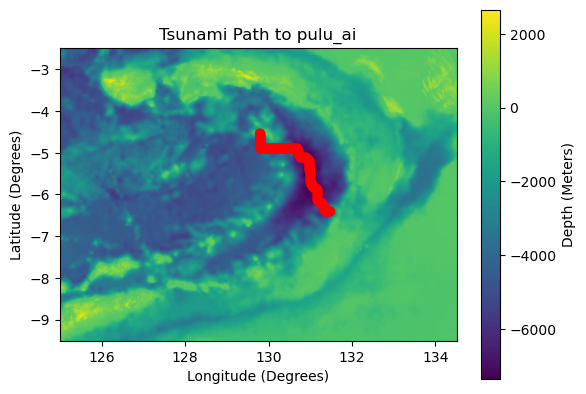

Dijkstra's arrival time for banda_neira: 31.49906092667582 minutes


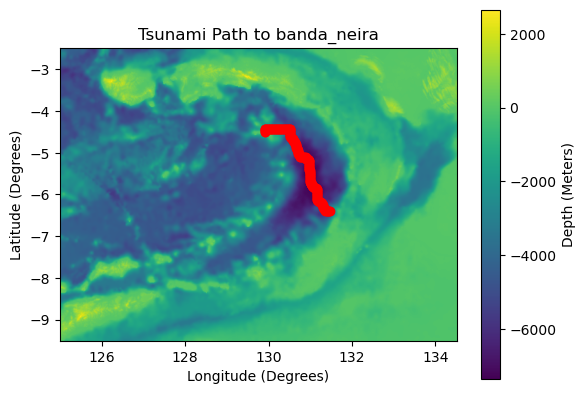

Dijkstra's arrival time for ambon: -1 minutes


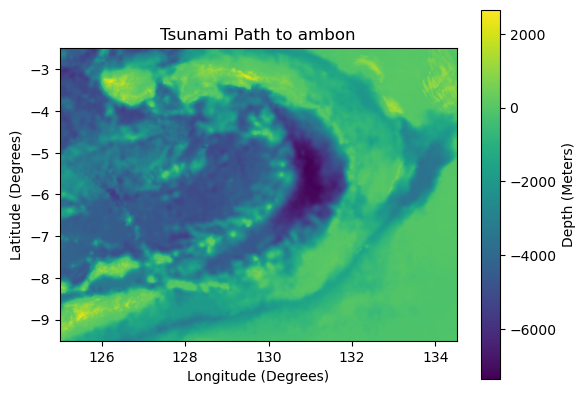

Dijkstra's arrival time for buru: 77.25997145218565 minutes


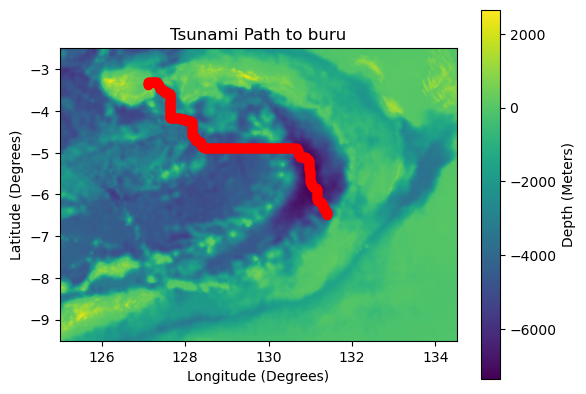

Dijkstra's arrival time for hulaliu: 56.16251513103086 minutes


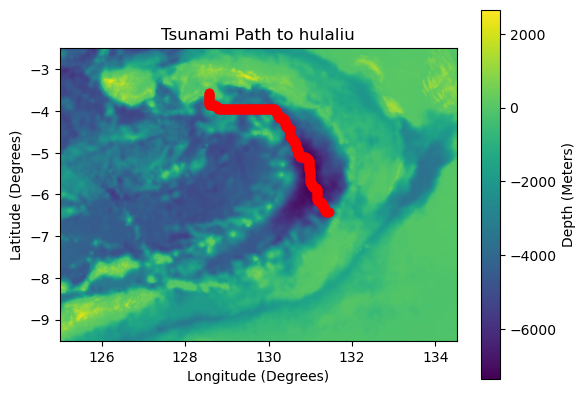

Dijkstra's arrival time for saparua: 57.10141046738649 minutes


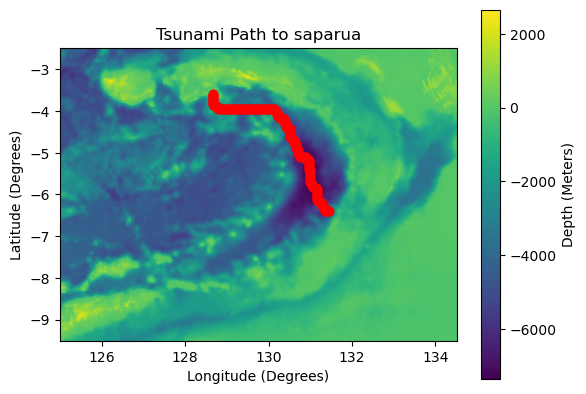

Dijkstra's arrival time for kulur: 63.419837429692286 minutes


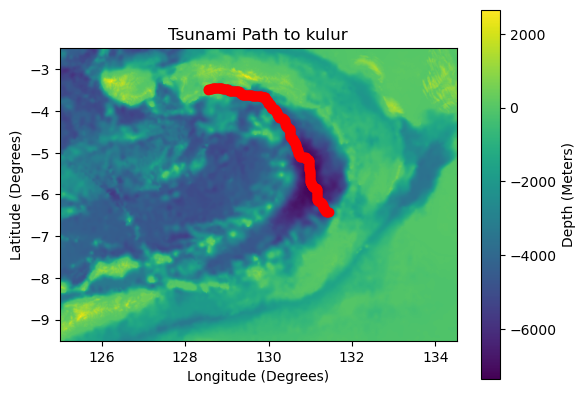

Dijkstra's arrival time for ameth: 48.65789428957609 minutes


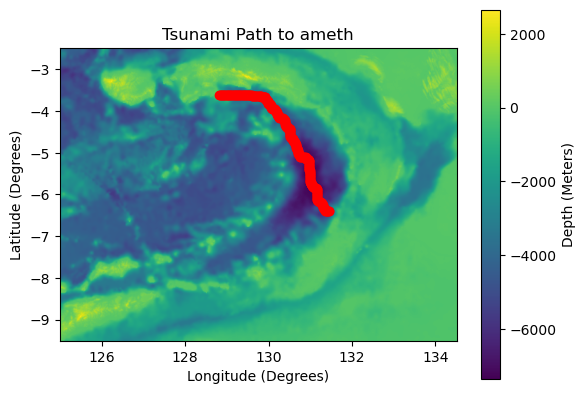

Dijkstra's arrival time for amahai: 48.639092500583544 minutes


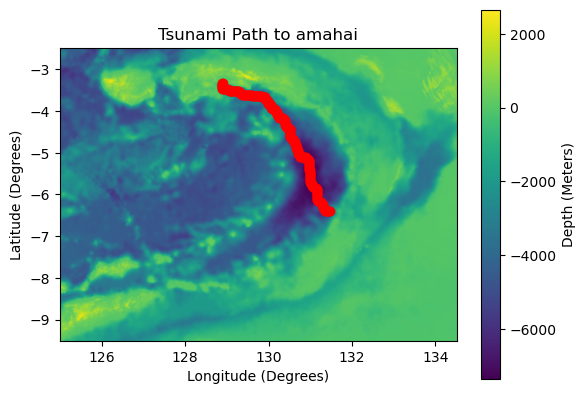

Elapsed time: 25.24025011062622 seconds
Dijkstra's arrival time for pulu_ai: 30.053993679340042 minutes


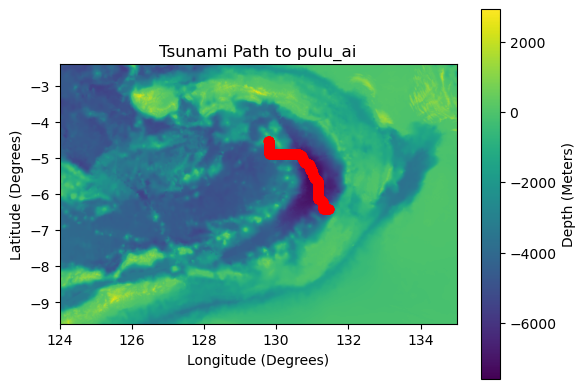

Dijkstra's arrival time for banda_neira: 33.1061174284035 minutes


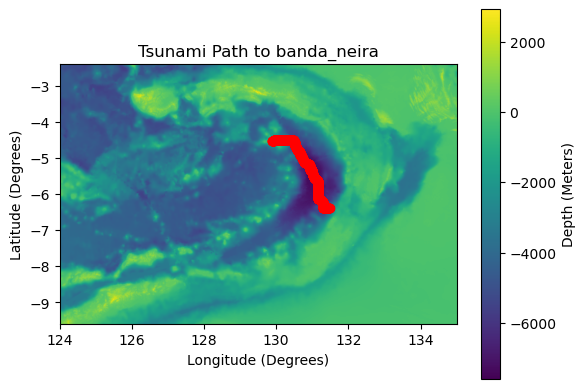

Dijkstra's arrival time for ambon: 59.221645413499225 minutes


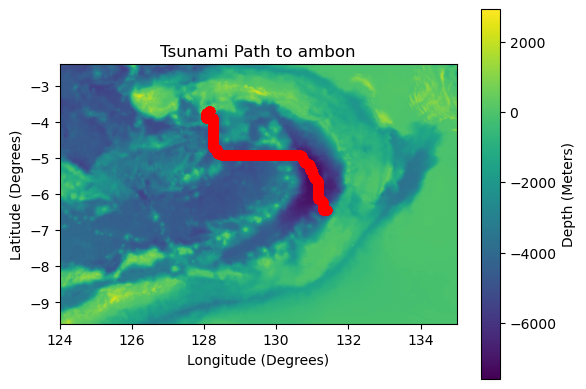

Dijkstra's arrival time for buru: 73.53897289265132 minutes


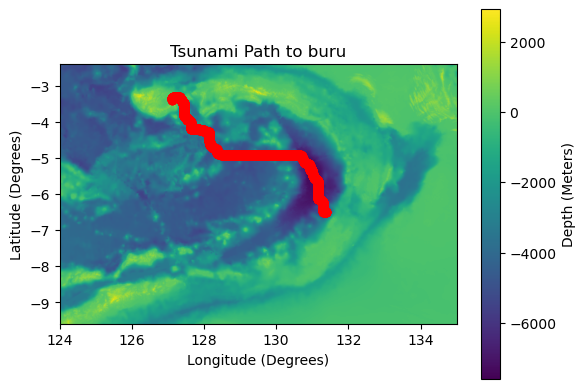

Dijkstra's arrival time for hulaliu: -1 minutes


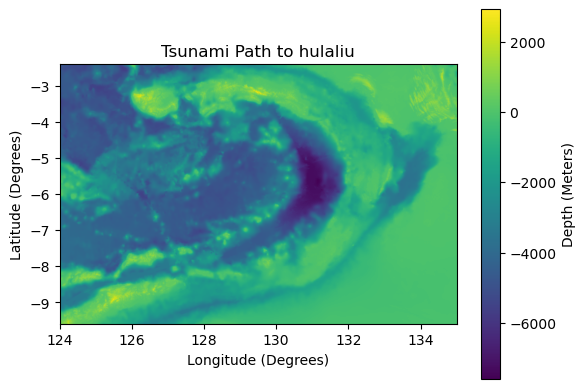

Dijkstra's arrival time for saparua: 57.317921776279064 minutes


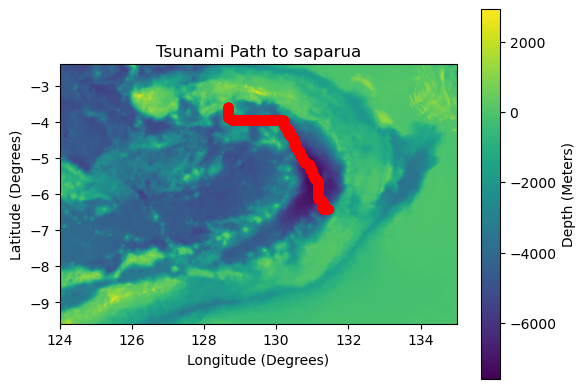

Dijkstra's arrival time for kulur: 59.68598122747998 minutes


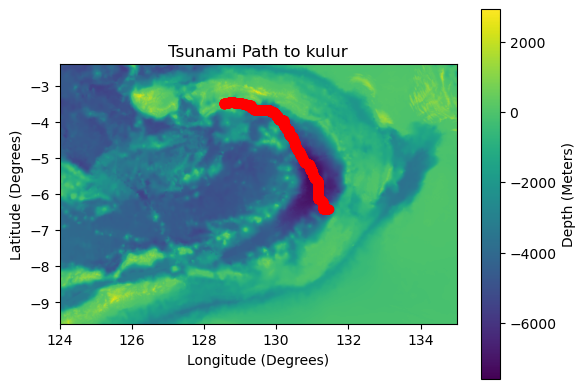

Dijkstra's arrival time for ameth: 56.47272101543185 minutes


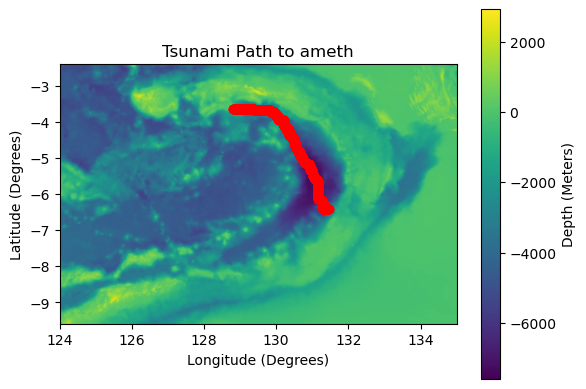

Dijkstra's arrival time for amahai: 48.982953474809236 minutes


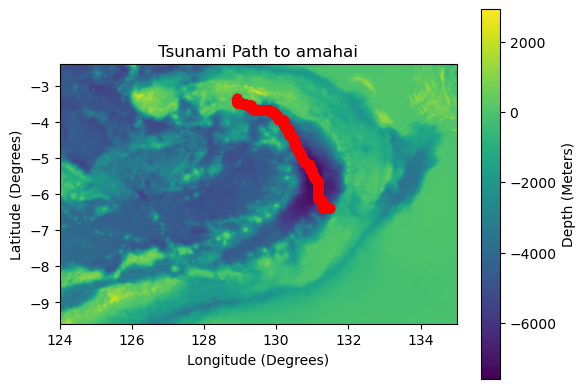

Elapsed time: 452.1179871559143 seconds


In [7]:
start_lat_long = earthquake_center
for file in bathy_data:
    start_time = time.time()
    time_model_instance = TimeModel(file, width)
    # Reshape the data into a 2D array (assuming it's a grid)
    rows = getattr(time_model_instance, "nrows")
    cols = getattr(time_model_instance, "ncols")
    grid_data = np.array(getattr(time_model_instance, "grid"))
    
    # Create X and Y coordinates for the grid
    xllcorner = getattr(time_model_instance, "xllcorner")
    yllcorner = getattr(time_model_instance, "yllcorner")
    cellsize = getattr(time_model_instance, "cellsize")
    xlrcorner = xllcorner + cols * cellsize
    yulcorner = yllcorner + rows * cellsize
    for location_name, end_lat_long in locations.items():
                # Plot the data using Matplotlib's imshow function
                plt.imshow(grid_data, extent=(xllcorner, xlrcorner, yllcorner, yulcorner), cmap='viridis')
                plt.colorbar(label='Depth (Meters)')
                plt.xlabel('Longitude (Degrees)')
                plt.ylabel('Latitude (Degrees)')
                start_lat_long = earthquake_center
                # Create an instance of TimeModel and run Dijkstra's algorithm
                path, total_time = time_model_instance.dijkstras_algorithm(start_lat_long,end_lat_long)
                print(f'Dijkstra\'s arrival time for {location_name}: {total_time} minutes')
                plt.title(f'Tsunami Path to {location_name}')
                coordinates = path
                if path:
                    x_coords, y_coords = zip(*coordinates)
                    # Plot the path or line
                    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='red', label='Path')

                plt.show()
                
                # if total_time > -1:# Create an instance of TimeModelSimpsons and run Simpson's method
                #     control_points = np.array(path)
                #     runner = TimeModelSimpsons(control_points)
                #     result = runner.simpson(0.0, 1.0, 3000)
                #     result_minutes = (result * 111120) / 60
                #     print(f'Simpson\'s arrival time for {location_name}: {result_minutes} minutes')
    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time} seconds")
            